# VarClump2D: Agglomeration test


In [1]:
%matplotlib inline

import os
import sys
import copy
import time
from array import array
import numpy as np
np.seterr(over='ignore')
import scipy as sp
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.interpolate import RegularGridInterpolator
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from ipywidgets import interact, interactive, fixed, FloatSlider

# autoreload user modules functionality
%load_ext autoreload
%autoreload 2

# VarClump functions
sys.path.append('../lib/')
from utils import *
from graph import *
from points_generation import *
from initial_guess import *
from variational import *
from gmr import *

# just for presentation
import warnings
warnings.filterwarnings("ignore")

## Loading `Orion KL`

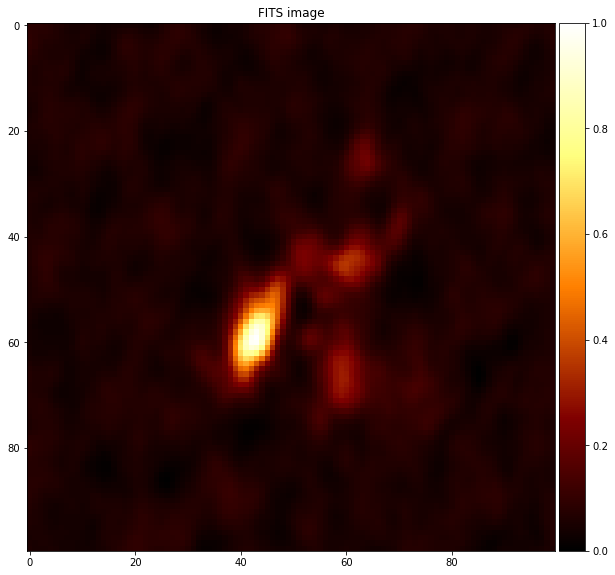

In [2]:
"""
Loading data
"""

fits_path = '../data/images/Orion.cont.image.fits'
x, y, data, dfunc = load_data(fits_path)
image_plot(data)

In [3]:
base_level = estimate_rms(data)
interact(thresholded_image_plot, data=fixed(data), level=FloatSlider(min=base_level,max=1.,step=0.01,value=base_level))

<function graph.thresholded_image_plot>

# Experiment: Generating an `ELM` instance

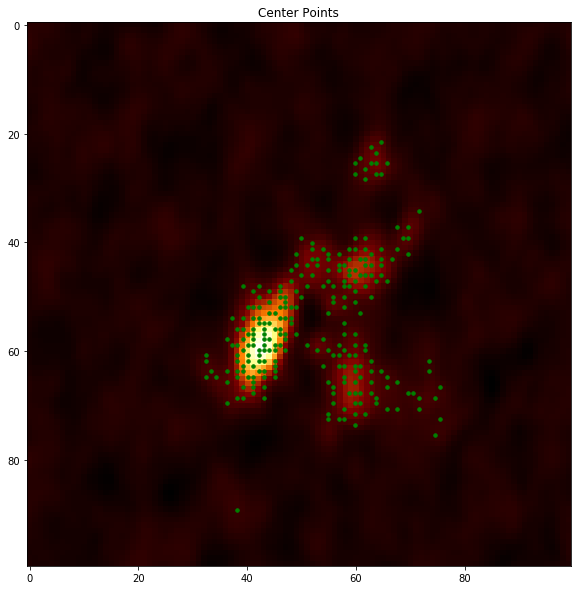

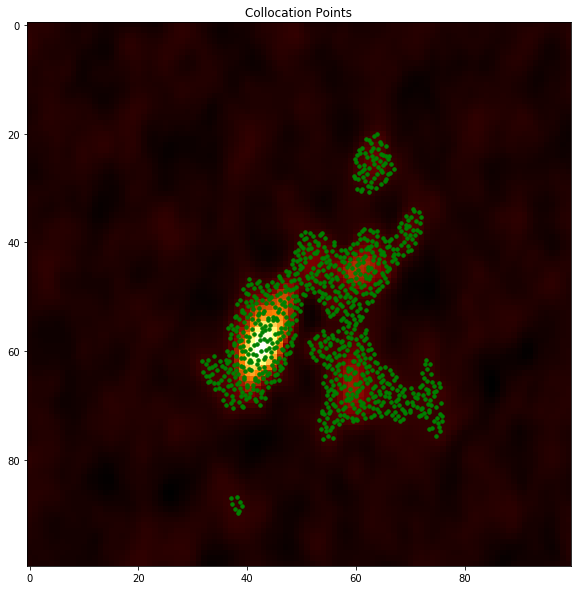

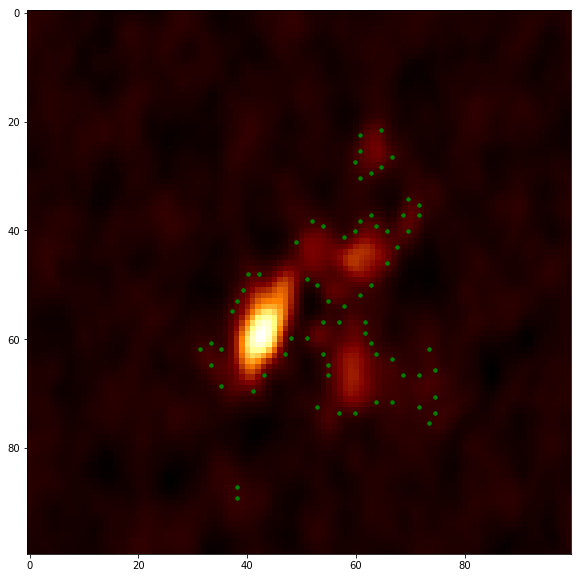

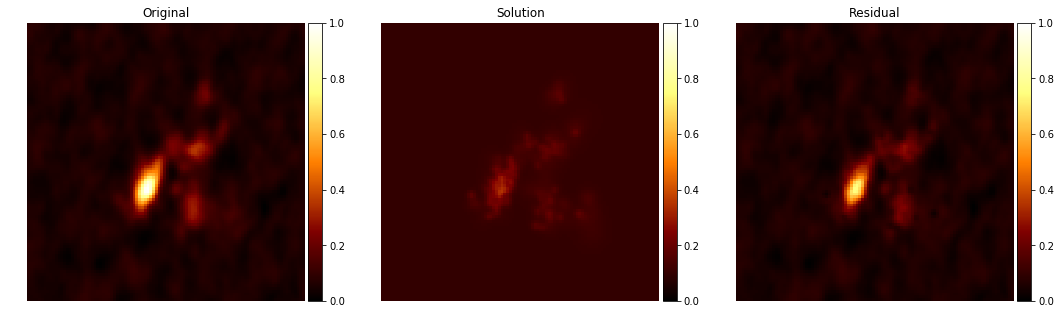

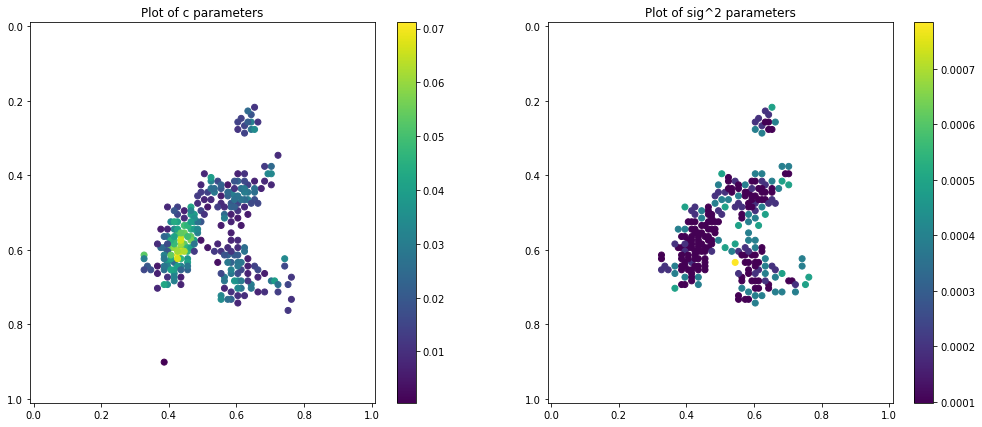

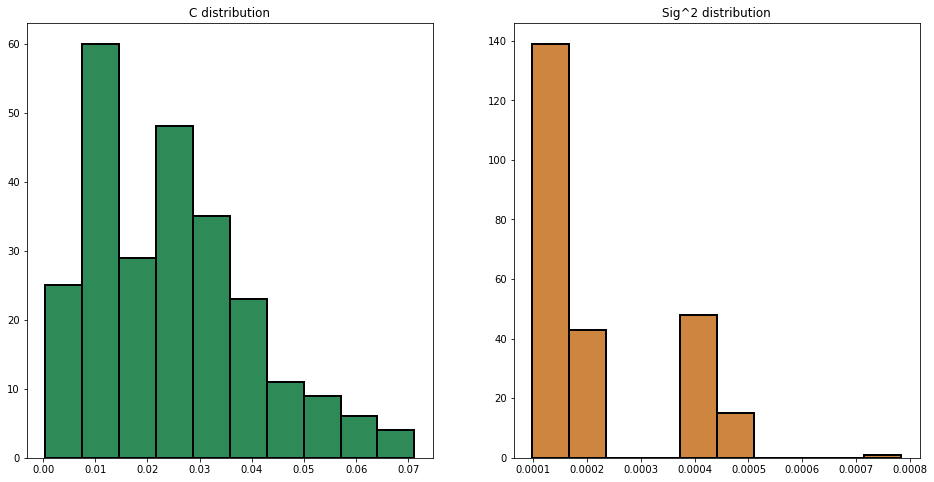

In [4]:
Nc = 250
Nb = int(0.2* np.sum(boundary_map(data, base_level))) #20% of boundary pixels
Ne = 4*Nc - Nb

center_points = random_centers_generation(data, Nc, base_level=base_level, power=3.)
collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
boundary_points = boundary_points_generation(data, base_level, Nb)


# right format
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
xb = boundary_points[:,0]
yb = boundary_points[:,1]


# visualizing the choosen points
points_plot(data, center_points=center_points, title="Center Points")
points_plot(data, center_points=collocation_points, title="Collocation Points")
points_plot(data, boundary_points=boundary_points, title="Boundary Points")


####################################
# Initial parameters estimation
####################################
minsig = ( 0.5*(1./data.shape[0] + 1./data.shape[1]) ) / 6.
maxsig = 30*minsig
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')

solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level)
params_plot(c0, sig0, xc, yc)
params_distribution_plot(c0, sig0)


elm01 = ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=1., lamb1=1., d1psi1=d1psi, 
                d1psi2=d1psi, d2psi2=d2psi, base_level=base_level, pix_freedom=1.)


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: False
status: 5
message: Number of calls to function has reached maxfev = 100100.
nfev: 100109

Residual stats:
Residual RMS: 0.0041289728890513905
Residual Variance: 1.6765507389887453e-05
Added Flux: 1.1781417577698183
Psi1(u-f): 0.0005194120193937786
#Exceeded Pixels: 433
Sharpness: 3.8205958697200466
Psi2(grad u): 0.024770075845953962
Total elapsed time: 288.2514328956604 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.03368965969923373
Mean min distance between collocation and center points: 0.009546047123767873

Homogeneity of solution:
Mean min distance in the (standarized) parameters space: 0.07440171913177117
Max min distance in the (standarized) parameters space: 0.5747975762692826


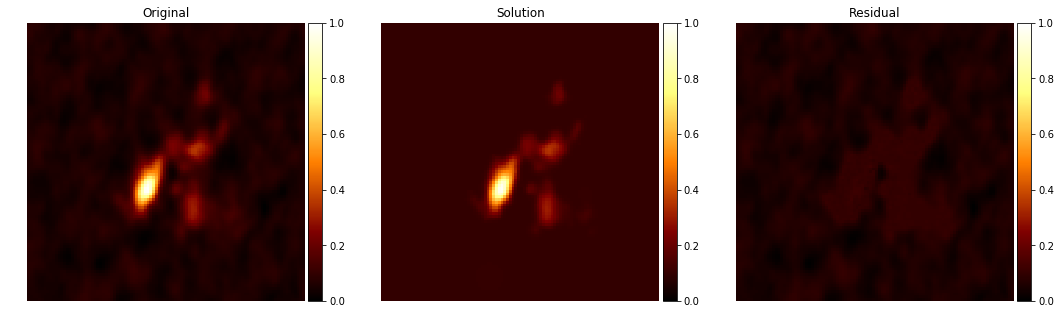

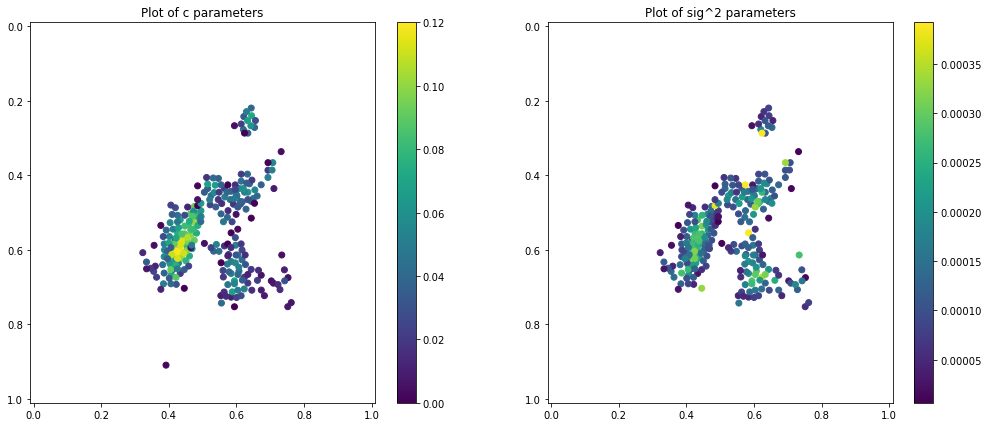

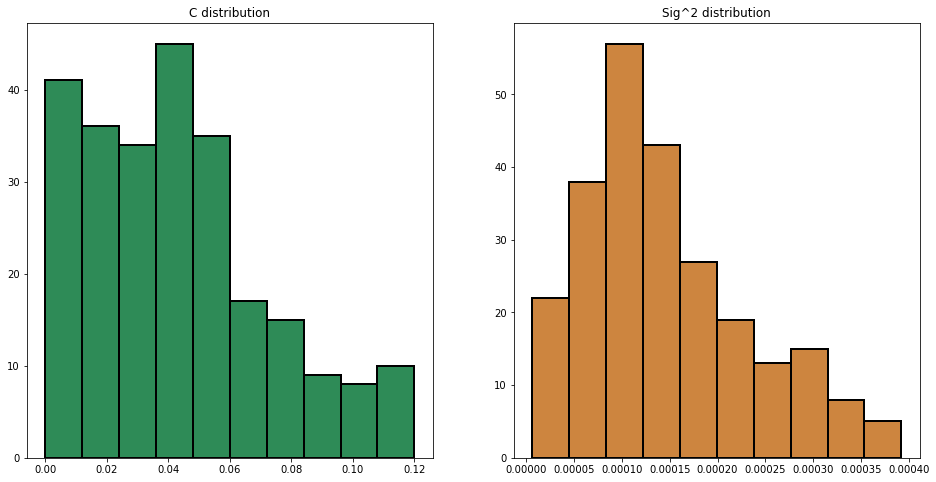

In [5]:
nfev = 100*(len(elm01.get_params())+1)
elm_solver(elm01, method='standard', max_nfev=nfev)

In [6]:
elm01.prune()
xc, yc, c, sig = elm01.get_params_mapped()
w = elm01.get_w()
mu = np.vstack([xc, yc]).T

### Agglomeration with `KL-divergence` (upper bound)

In [7]:
components_dict01, isd_hist, kl_hist = gaussian_reduction(w, mu, sig, n_comp=1, metric='KL', verbose=True)

Merged components 113 and 186 with 3.814519346548827e-09 KL dist and 4.645467495921485e-16 ISD dist
Merged components 101 and 140 with 2.2812824778825793e-07 KL dist and 1.828614936478315e-11 ISD dist
Merged components 105 and 220 with 2.5794363976558026e-07 KL dist and 2.6832438697358982e-11 ISD dist
Merged components 108 and 136 with 3.311365590588629e-07 KL dist and 7.125463080292838e-11 ISD dist
Merged components 146 and 216 with 3.383228850567814e-07 KL dist and 6.848299606910815e-11 ISD dist
Merged components 73 and 88 with 4.87830701846751e-07 KL dist and 1.9471218925754468e-10 ISD dist
Merged components 104 and 171 with 7.70187516158506e-07 KL dist and 2.71990225467949e-10 ISD dist
Merged components 109 and 111 with 8.292862581453498e-07 KL dist and 6.578632900662055e-10 ISD dist
Merged components 133 and 216 with 8.751487519606267e-07 KL dist and 7.464009614350376e-10 ISD dist
Merged components 24 and 178 with 1.2780936911871974e-06 KL dist and 3.3328211060053064e-11 ISD dist


Merged components 36 and 85 with 1.0627921897767467e-05 KL dist and 7.3337273002919936e-09 ISD dist
Merged components 25 and 65 with 1.075632272256398e-05 KL dist and 2.6200412376995805e-08 ISD dist
Merged components 21 and 83 with 1.091865944592978e-05 KL dist and 1.6858564966265367e-08 ISD dist
Merged components 55 and 91 with 1.1140285646178618e-05 KL dist and 1.4112197710714364e-08 ISD dist
Merged components 51 and 73 with 1.1339596035436563e-05 KL dist and 2.1206832930751472e-08 ISD dist
Merged components 77 and 109 with 1.168208395145023e-05 KL dist and 3.358615359678304e-09 ISD dist
Merged components 59 and 90 with 1.1890164708380259e-05 KL dist and 2.6398356866952453e-08 ISD dist
Merged components 26 and 107 with 1.2199642966862542e-05 KL dist and 1.9155392751659295e-09 ISD dist
Merged components 5 and 63 with 1.2444876926754212e-05 KL dist and 2.8918018453810376e-09 ISD dist
Merged components 35 and 52 with 1.2580337684840964e-05 KL dist and 7.751795265468702e-09 ISD dist
Merg

Merged components 12 and 18 with 5.909469821681855e-05 KL dist and 1.713507065285768e-07 ISD dist
Merged components 2 and 23 with 5.9460384658685875e-05 KL dist and 2.607480417408345e-07 ISD dist
Merged components 3 and 8 with 6.122504129877444e-05 KL dist and 1.9453586462526117e-07 ISD dist
Merged components 6 and 38 with 6.670287484843791e-05 KL dist and 5.341565630889689e-07 ISD dist
Merged components 3 and 12 with 6.783539881414103e-05 KL dist and 5.052050801033131e-08 ISD dist
Merged components 6 and 29 with 7.210629376120325e-05 KL dist and 2.8179208868768285e-07 ISD dist
Merged components 9 and 10 with 7.224000566013198e-05 KL dist and 5.071972882984507e-07 ISD dist
Merged components 5 and 9 with 7.306519468251792e-05 KL dist and 3.154308431385633e-07 ISD dist
Merged components 13 and 17 with 8.065617783053233e-05 KL dist and 5.07154585254053e-07 ISD dist
Merged components 14 and 19 with 8.151517875581472e-05 KL dist and 3.2523582146118244e-07 ISD dist
Merged components 2 and 35

In [8]:
interact(components_plot, elm=fixed(elm01), data=fixed(data), components_dict=fixed(components_dict01), n_comp=(1,20), dims=fixed(data.shape), resolution=fixed(1), n_levels=fixed(5))

<function graph.components_plot>

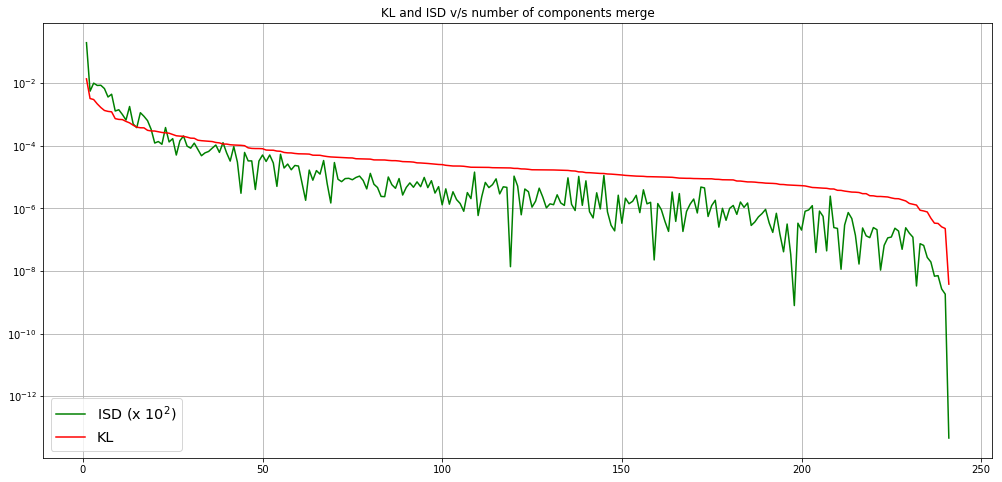

In [9]:
ncomp = list(range(len(isd_hist),0,-1))
plt.figure(figsize=(17,8))
plt.semilogy(ncomp, 1e2*isd_hist, "g-", label='ISD (x$\ 10^2$)')
plt.semilogy(ncomp, kl_hist, "r-", label='KL')
plt.title("KL and ISD v/s number of components merge")
plt.grid()
plt.legend(loc='lower left', fontsize="x-large")
plt.show()

### Agglomeration with `ISD`

$$
d_{\textit{ISD}}(i,j) = \int_{\Omega} \left( (w_i \mathcal{N}(\mathbf{x}; \boldsymbol{\mu}_i, \Sigma_i) + w_j \mathcal{N}(\mathbf{x}; \boldsymbol{\mu}_j, \Sigma_j) ) - (w_m \mathcal{N}(\mathbf{x}; \boldsymbol{\mu}_m, \Sigma_m))  \right)^2 d\mathbf{x}
$$

In [8]:
components_dict02, isd_hist02, kl_hist02 = gaussian_reduction(w, mu, sig, n_comp=1, metric='ISD', verbose=True)

Merged components 113 and 186 with 4.645467495921485e-16 ISD dist
Merged components 88 and 200 with 6.450809908232379e-12 ISD dist
Merged components 13 and 143 with 7.89530467049717e-12 ISD dist
Merged components 218 and 232 with 1.064025696467997e-11 ISD dist
Merged components 138 and 234 with 1.767091442112954e-11 ISD dist
Merged components 23 and 187 with 3.3328211060053064e-11 ISD dist
Merged components 105 and 146 with 5.219774897256288e-11 ISD dist
Merged components 106 and 134 with 7.125463080292838e-11 ISD dist
Merged components 121 and 209 with 1.073379376401084e-10 ISD dist
Merged components 51 and 222 with 1.1383190951908985e-10 ISD dist
Merged components 1 and 92 with 1.37728893712791e-10 ISD dist
Merged components 138 and 217 with 1.6723446065183328e-10 ISD dist
Merged components 6 and 70 with 2.2583451085650072e-10 ISD dist
Merged components 23 and 138 with 3.3869581990003943e-10 ISD dist
Merged components 161 and 220 with 3.8686165696522653e-10 ISD dist
Merged components

Merged components 15 and 106 with 2.7214736432924486e-08 ISD dist
Merged components 7 and 52 with 2.7661878611104368e-08 ISD dist
Merged components 38 and 99 with 2.7897089854336178e-08 ISD dist
Merged components 0 and 44 with 2.8226223963992043e-08 ISD dist
Merged components 24 and 101 with 2.851777117838938e-08 ISD dist
Merged components 2 and 32 with 3.0231472014572745e-08 ISD dist
Merged components 12 and 28 with 3.155285833980816e-08 ISD dist
Merged components 13 and 26 with 3.203352232000007e-08 ISD dist
Merged components 33 and 71 with 3.4592631223400767e-08 ISD dist
Merged components 24 and 48 with 3.562362482094652e-08 ISD dist
Merged components 16 and 36 with 3.5659780349221664e-08 ISD dist
Merged components 6 and 61 with 3.5820331314366215e-08 ISD dist
Merged components 15 and 22 with 4.030286743723479e-08 ISD dist
Merged components 6 and 27 with 4.1519320572154807e-08 ISD dist
Merged components 1 and 7 with 4.152831040690016e-08 ISD dist
Merged components 13 and 99 with 3.1

In [10]:
interact(components_plot, elm=fixed(elm01), data=fixed(data), components_dict=fixed(components_dict02), n_comp=(1,20), dims=fixed(data.shape), resolution=fixed(1), n_levels=fixed(5))

<function graph.components_plot>

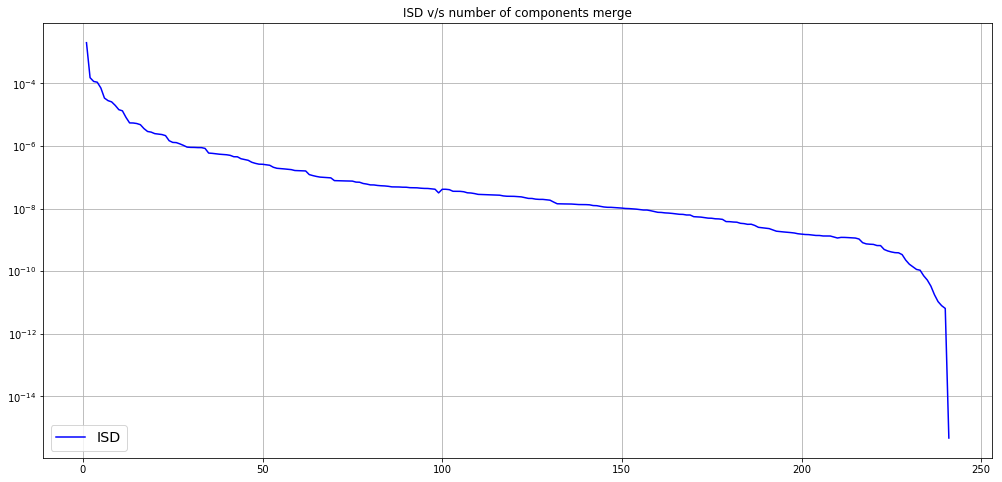

In [18]:
ncomp = list(range(len(isd_hist02),0,-1))
plt.figure(figsize=(17,8))
plt.semilogy(ncomp, isd_hist02, "b-", label='ISD')
plt.title("ISD v/s number of components merge")
plt.grid()
plt.legend(loc='lower left', fontsize="x-large")
plt.show()

### Agglomeration with normalized `ISD`

$$
d_{\textit{ISD}}(i,j) = \int_{\Omega} \left( (\frac{w_i}{w_m} \mathcal{N}(\mathbf{x}; \boldsymbol{\mu}_i, \Sigma_i) + \frac{w_j}{w_m} \mathcal{N}(\mathbf{x}; \boldsymbol{\mu}_j, \Sigma_j) ) - (\mathcal{N}(\mathbf{x}; \boldsymbol{\mu}_m, \Sigma_m))  \right)^2 d\mathbf{x}
$$

In [19]:
components_dict03, isd_hist03, kl_hist03 = gaussian_reduction(w, mu, sig, n_comp=1, metric='ISD_', verbose=True)

Merged components 113 and 186 with 2.516250674489129e-08 ISD dist
Merged components 13 and 144 with 0.00035309987396203724 ISD dist
Merged components 1 and 95 with 0.000610316306307368 ISD dist
Merged components 137 and 236 with 0.0009564100779755336 ISD dist
Merged components 135 and 236 with 0.0011440539599902877 ISD dist
Merged components 19 and 54 with 0.0034889564732623057 ISD dist
Merged components 21 and 183 with 0.003658727306003584 ISD dist
Merged components 83 and 190 with 0.005201376046443329 ISD dist
Merged components 119 and 208 with 0.00657000033913846 ISD dist
Merged components 29 and 100 with 0.006682448443143585 ISD dist
Merged components 6 and 68 with 0.006813257544308726 ISD dist
Merged components 22 and 139 with 0.007644989375933164 ISD dist
Merged components 135 and 222 with 0.008772852007012943 ISD dist
Merged components 77 and 228 with 0.01039313148945098 ISD dist
Merged components 0 and 75 with 0.01343718886306533 ISD dist
Merged components 45 and 213 with 0.015

Merged components 10 and 109 with 0.0790699920938458 ISD dist
Merged components 32 and 108 with 0.07801296998128215 ISD dist
Merged components 42 and 107 with 0.07916214265821786 ISD dist
Merged components 39 and 106 with 0.07946464241950046 ISD dist
Merged components 18 and 105 with 0.07915192412905903 ISD dist
Merged components 44 and 104 with 0.08204218882210412 ISD dist
Merged components 12 and 103 with 0.08222796739587324 ISD dist
Merged components 58 and 102 with 0.08706322453996229 ISD dist
Merged components 36 and 101 with 0.08741739122778469 ISD dist
Merged components 27 and 100 with 0.08804615917541803 ISD dist
Merged components 24 and 99 with 0.08540914960346768 ISD dist
Merged components 54 and 98 with 0.0845250114196201 ISD dist
Merged components 72 and 97 with 0.08328295300730204 ISD dist
Merged components 32 and 96 with 0.08062606474499745 ISD dist
Merged components 46 and 95 with 0.06429089472256422 ISD dist
Merged components 68 and 94 with 0.07616543093105932 ISD dist


In [20]:
interact(components_plot, elm=fixed(elm01), data=fixed(data), components_dict=fixed(components_dict03), n_comp=(1,20), dims=fixed(data.shape), resolution=fixed(1), n_levels=fixed(5))

<function graph.components_plot>

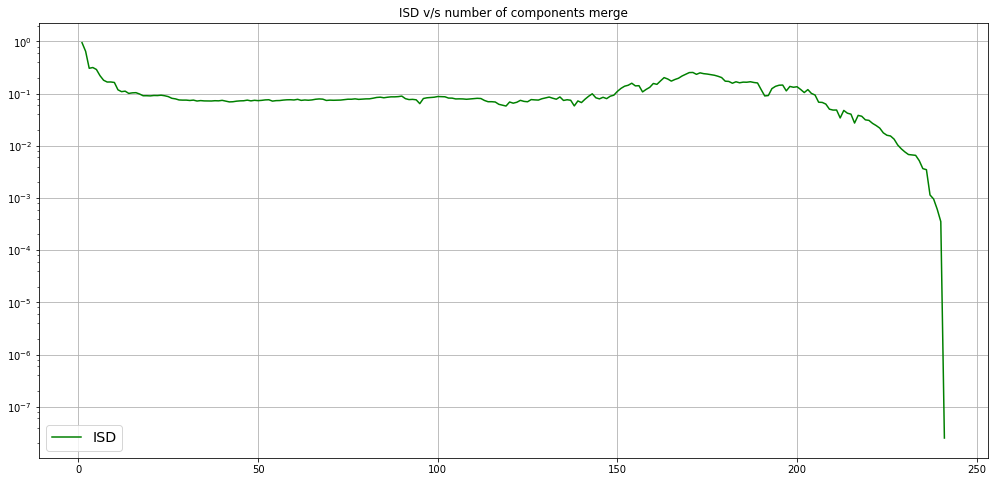

In [21]:
ncomp = list(range(len(isd_hist03),0,-1))
plt.figure(figsize=(17,8))
plt.semilogy(ncomp, isd_hist03, "g-", label='ISD')
plt.title("ISD v/s number of components merge")
plt.grid()
plt.legend(loc='lower left', fontsize="x-large")
plt.show()

### Agglomeration with `ISD`: Maray's Approach

In [11]:
components_dict04, isd_hist = gaussian_reduction_(w, mu, sig, n_comp=1, verbose=True)

Merged components 113 and 186 with 4.645467495921485e-16 ISD dist
Merged components 88 and 200 with 6.450809908232379e-12 ISD dist
Merged components 13 and 143 with 7.895304665414972e-12 ISD dist
Merged components 218 and 232 with 1.064025696467997e-11 ISD dist
Merged components 138 and 234 with 1.7653900330357158e-11 ISD dist
Merged components 23 and 187 with 3.3328211060053064e-11 ISD dist
Merged components 105 and 146 with 5.219774897256288e-11 ISD dist
Merged components 106 and 134 with 7.125463080303426e-11 ISD dist
Merged components 121 and 209 with 1.073379376324851e-10 ISD dist
Merged components 51 and 222 with 1.1383190951951336e-10 ISD dist
Merged components 1 and 92 with 1.3772889369923847e-10 ISD dist
Merged components 138 and 217 with 1.6723446065193916e-10 ISD dist
Merged components 6 and 70 with 2.258345108717473e-10 ISD dist
Merged components 23 and 138 with 3.3869581990342756e-10 ISD dist
Merged components 18 and 50 with 3.9139246096902723e-10 ISD dist
Merged component

Merged components 16 and 44 with 3.622803575722365e-08 ISD dist
Merged components 34 and 41 with 3.7956783963868365e-08 ISD dist
Merged components 37 and 68 with 3.9967601431056906e-08 ISD dist
Merged components 17 and 25 with 4.030286743723479e-08 ISD dist
Merged components 5 and 41 with 4.0499638212035676e-08 ISD dist
Merged components 41 and 65 with 4.143514565942028e-08 ISD dist
Merged components 1 and 7 with 4.152831040689677e-08 ISD dist
Merged components 5 and 28 with 4.1975456676759516e-08 ISD dist
Merged components 4 and 24 with 4.422835261791972e-08 ISD dist
Merged components 9 and 72 with 4.506918960294488e-08 ISD dist
Merged components 13 and 25 with 4.5193546557985596e-08 ISD dist
Merged components 19 and 22 with 4.6908901112707393e-08 ISD dist
Merged components 13 and 80 with 4.741078041094131e-08 ISD dist
Merged components 25 and 71 with 4.784860758792178e-08 ISD dist
Merged components 20 and 63 with 4.8394010530671865e-08 ISD dist
Merged components 2 and 23 with 5.01600

In [12]:
interact(components_plot, elm=fixed(elm01), data=fixed(data), components_dict=fixed(components_dict04), n_comp=(1,20), dims=fixed(data.shape), resolution=fixed(1), n_levels=fixed(5))

<function graph.components_plot>

### Agglomeration with `ISD`: Original William's Approach

In [13]:
components_dict05, isd_hist = gaussian_reduction__(w, mu, sig, n_comp=1, verbose=True)

Merged components 113 and 186 with 4.649058915617843e-16 ISD dist


NameError: name 'isd_hist' is not defined

## Conclusion: `Use the KL-divergence (upper bound), Runall approach. `

***
***

# `M100`

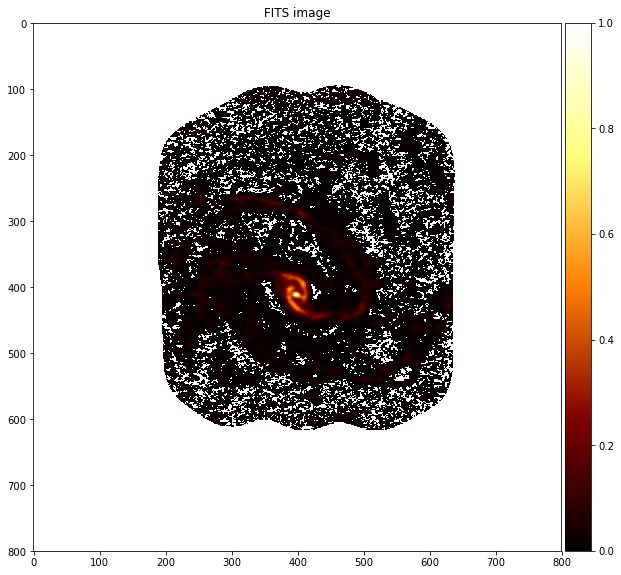

In [2]:
"""
Loading data
"""

fits_path = '../data/images/M100_combine_CO_cube.image.mom0.pbcor.fits'
x, y, data, dfunc = load_data(fits_path)
image_plot(data)

In [3]:
base_level = estimate_rms(data)
interact(thresholded_image_plot, data=fixed(data), level=FloatSlider(min=base_level,max=1.,step=0.01,value=base_level))

/Users/mavillan/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:3902: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  check = self.filled(0).__eq__(other)


<function graph.thresholded_image_plot>

# Experiment: Generating an `ELM` instance

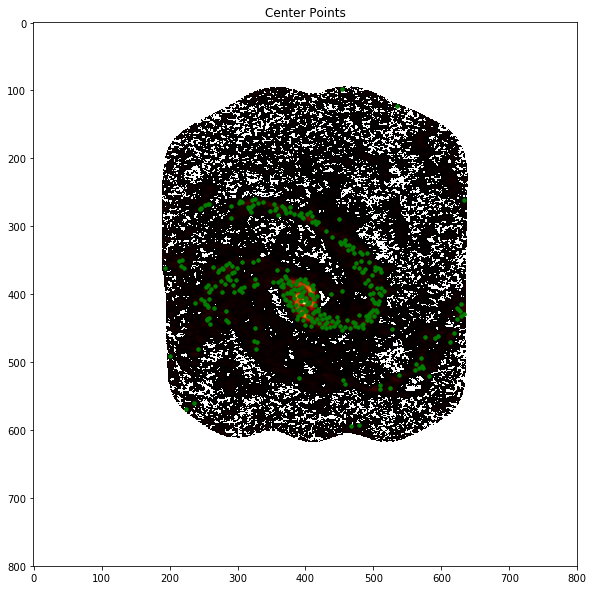

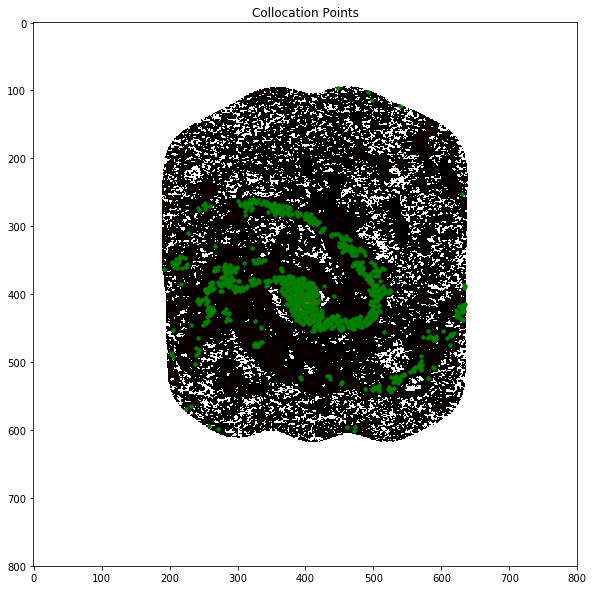

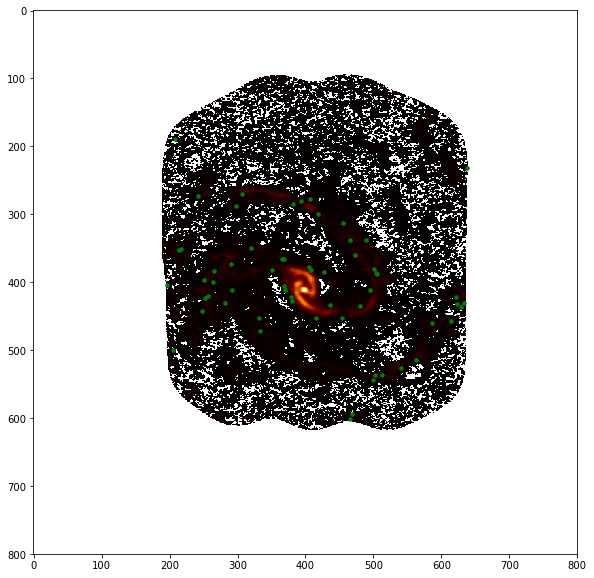

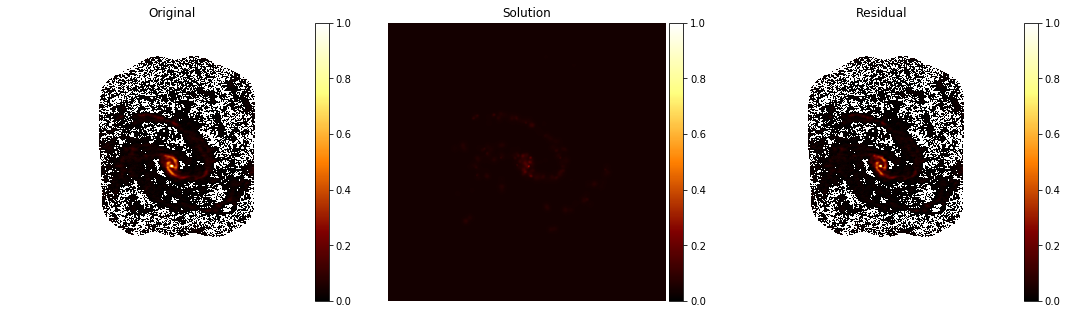

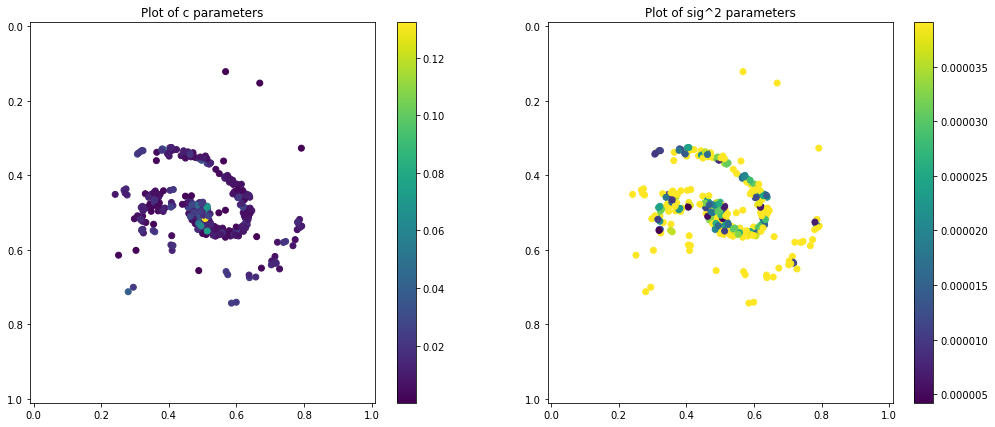

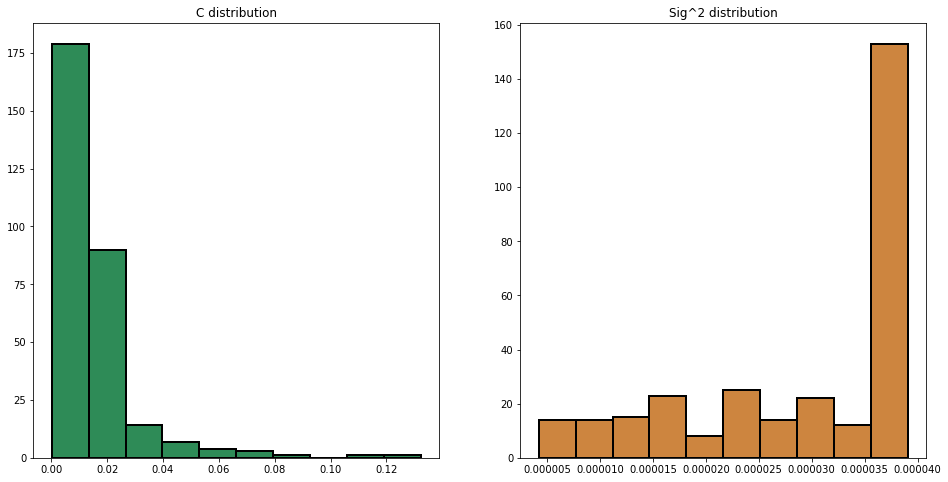

In [21]:
Nc = 300
Nb = int(0.2*Nc)
Ne = 3*Nc - Nb

#center_points = random_centers_generation(data, Nc, base_level=base_level, power=2.)
points = qrandom_centers_generation(dfunc, Nc+Ne, base_level, ndim=2)
center_points = points[0:Nc]
collocation_points = points[Nc:Nc+Ne]
#collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
boundary_points = boundary_points_generation(data, base_level, Nb)


# right format
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
xb = boundary_points[:,0]
yb = boundary_points[:,1]


# visualizing the choosen points
points_plot(data, center_points=center_points, title="Center Points")
points_plot(data, center_points=collocation_points, title="Collocation Points")
points_plot(data, boundary_points=boundary_points, title="Boundary Points")


####################################
# Initial parameters estimation
####################################
minsig = ( 0.5*(1./data.shape[0] + 1./data.shape[1]) ) / 6.
maxsig = 30*minsig
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')

solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level)
params_plot(c0, sig0, xc, yc)
params_distribution_plot(c0, sig0)


elm02 = ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=1., lamb1=1., d1psi1=d1psi, 
                d1psi2=d1psi, d2psi2=d2psi, base_level=base_level, pix_freedom=1.)


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: True
status: 2
message: The relative error between two consecutive iterates is at most 0.000000
nfev: 1211

Residual stats:
Residual RMS: 0.02356245877919558
Residual Variance: 0.0005487525489291211
Flux Lost: 0.07745813454004202
Flux Addition: 0.052574240654533054
psi1(u-f): 1.0459624651989752
Exceeded Pixels: 6682
Sharpness: 165.04738669178434
psi2(grad u): 2.0171382577869674
Total elapsed time: 15.916581153869629 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.0649081993334581
Mean min distance between collocation and center points: 0.005448859582450297

Homogeneity of solution:
Mean min distance in the (standarized) parameters space: 0.059982030526816006
Max min distance in the (standarized) parameters space: 0.52010938120

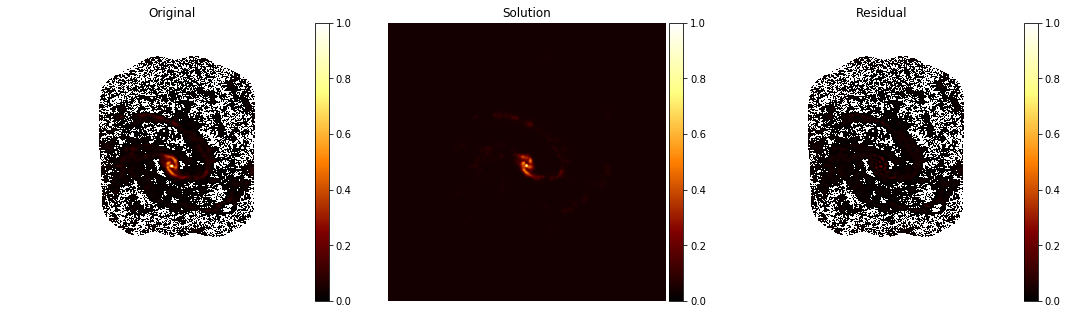

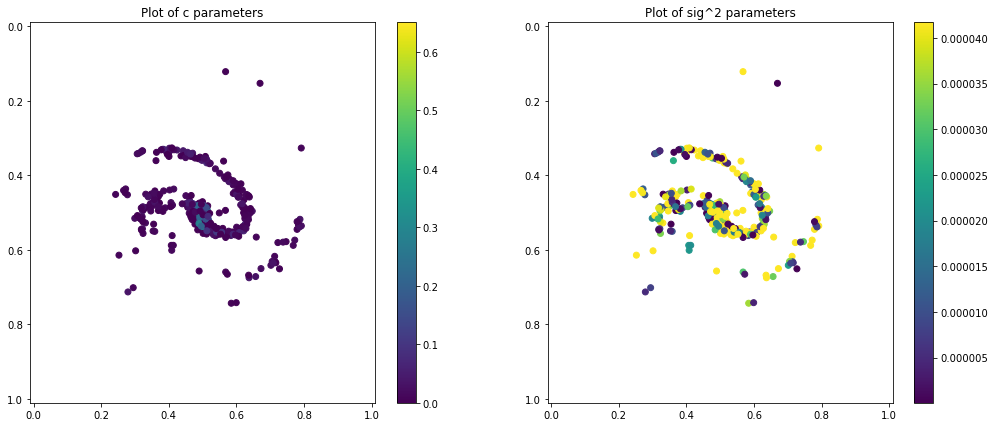

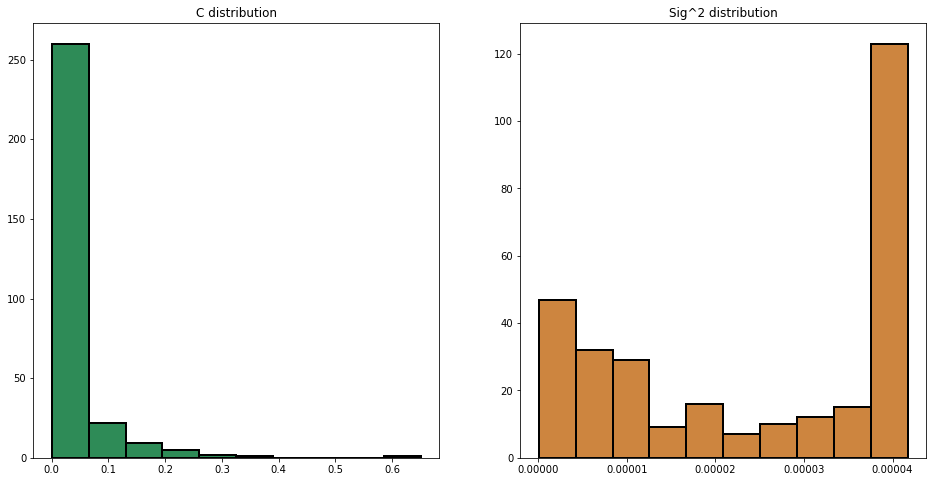

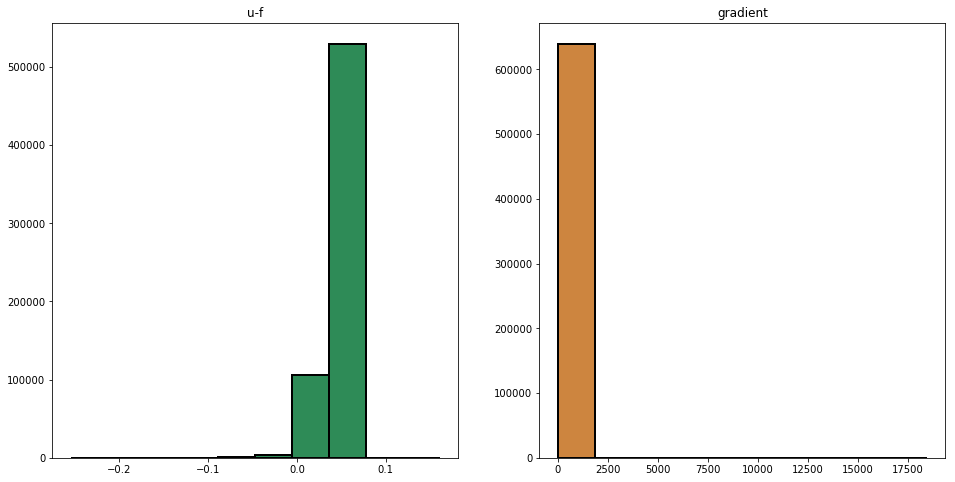

In [23]:
nfev = 100*(len(elm02.get_params())+1)
elm_solver(elm02, method='standard', max_nfev=nfev)

***
***

# `NGC3265`

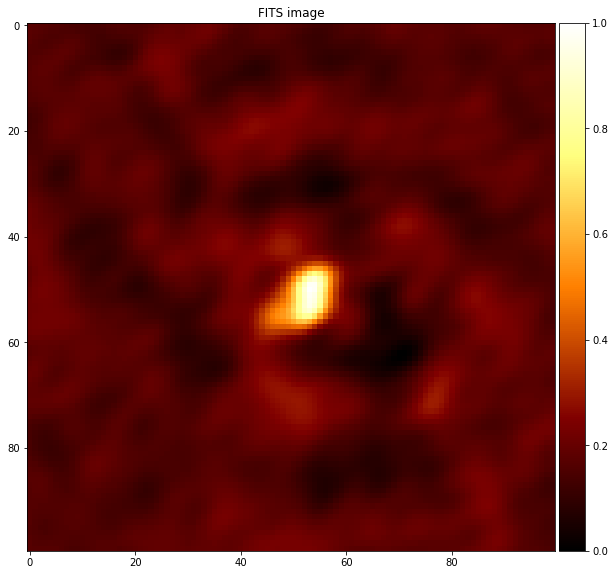

In [7]:
"""
Loading data
"""

fits_path = '../data/images/result-ngc3256_cont.image.fits'
x, y, data, dfunc = load_data(fits_path)
image_plot(data)

In [8]:
base_level = estimate_rms(data)
interact(thresholded_image_plot, data=fixed(data), level=FloatSlider(min=base_level,max=1.,step=0.01,value=base_level))

<function graph.thresholded_image_plot>

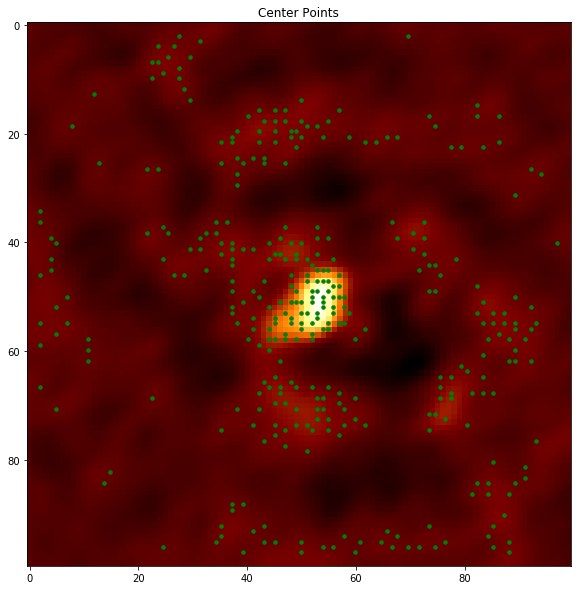

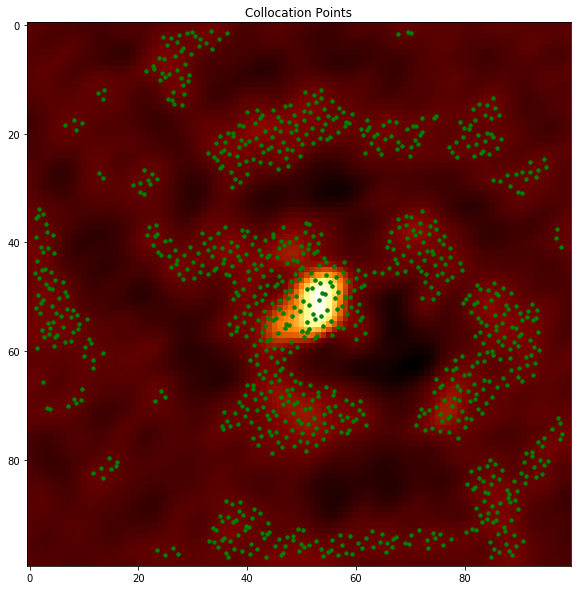

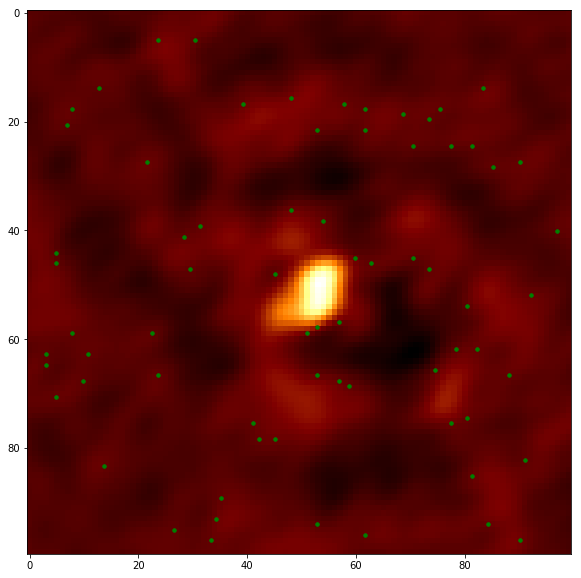

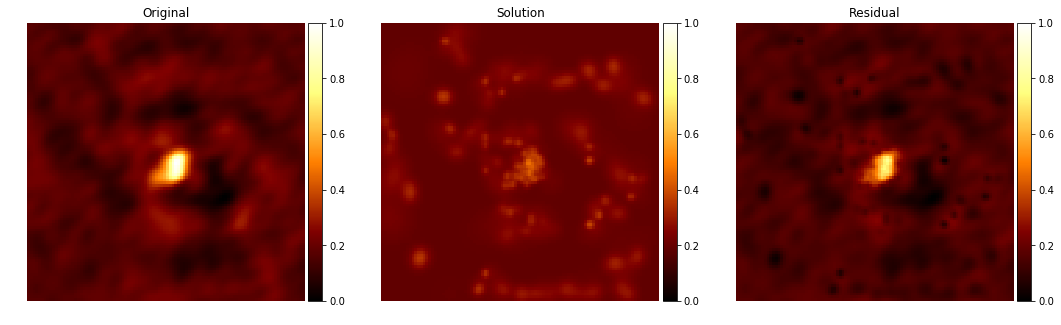

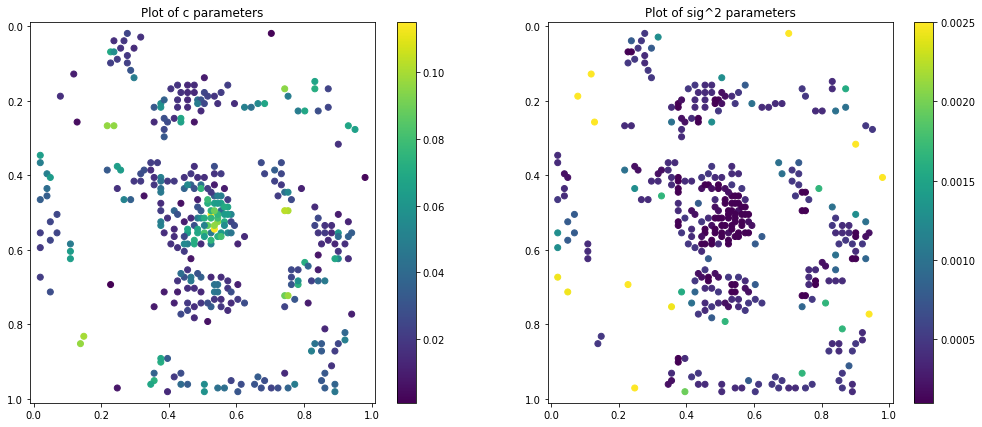

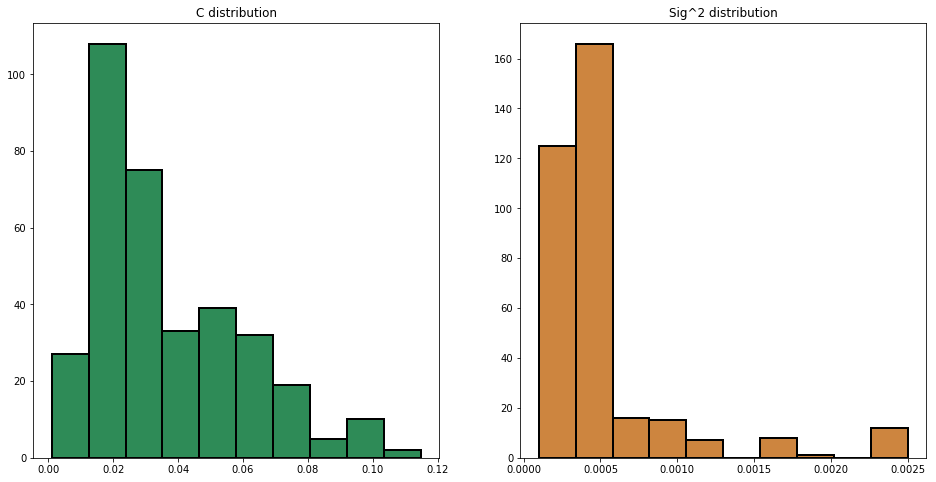

In [11]:
Nc = 350
Nb = int(0.2*Nc)
Ne = 3*Nc - Nb

center_points = random_centers_generation(data, Nc, base_level=base_level, power=3.)
#points = qrandom_centers_generation(dfunc, Nc+Ne, base_level, ndim=2)
#center_points = points[0:Nc]
#collocation_points = points[Nc:Nc+Ne]
collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
boundary_points = boundary_points_generation(data, base_level, Nb)


# right format
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
xb = boundary_points[:,0]
yb = boundary_points[:,1]


# visualizing the choosen points
points_plot(data, center_points=center_points, title="Center Points")
points_plot(data, center_points=collocation_points, title="Collocation Points")
points_plot(data, boundary_points=boundary_points, title="Boundary Points")


####################################
# Initial parameters estimation
####################################
minsig = ( 0.5*(1./data.shape[0] + 1./data.shape[1]) ) / 6.
maxsig = 30*minsig
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')

solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level)
params_plot(c0, sig0, xc, yc)
params_distribution_plot(c0, sig0)


elm03 = ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=1., lamb1=1., d1psi1=d1psi, 
                d1psi2=d1psi, d2psi2=d2psi, base_level=base_level, pix_freedom=1.)


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: True
status: 2
message: The relative error between two consecutive iterates is at most 0.000000
nfev: 25232

Residual stats:
Residual RMS: 0.007728239767424845
Residual Variance: 5.922973989688058e-05
Flux Lost: 0.012977405477647773
Flux Addition: 0.009976918881942017
psi1(u-f): 0.008537878462626838
Exceeded Pixels: 1453
Sharpness: 56.22987697094193
psi2(grad u): 2.772295384325599
Total elapsed time: 164.5791778564453 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.06685323719530491
Mean min distance between collocation and center points: 0.015097904750736192

Homogeneity of solution:
Mean min distance in the (standarized) parameters space: 0.0630086581165548
Max min distance in the (standarized) parameters space: 0.4126546567

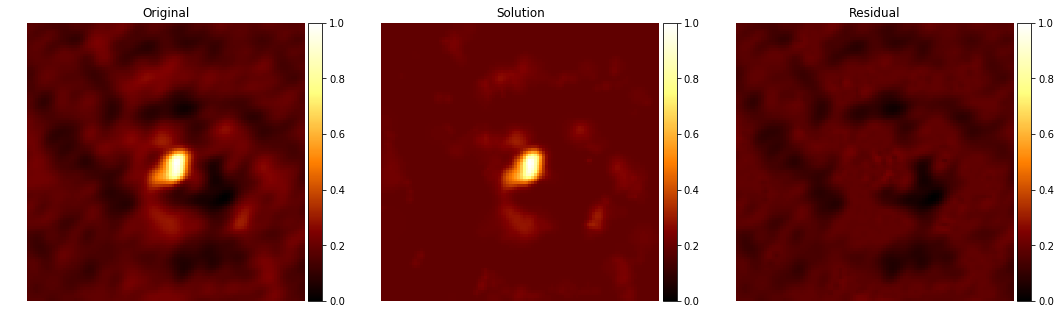

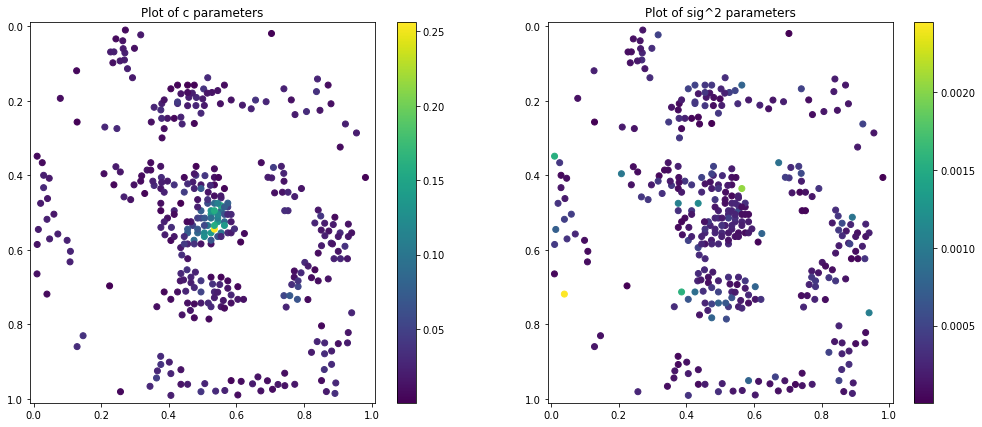

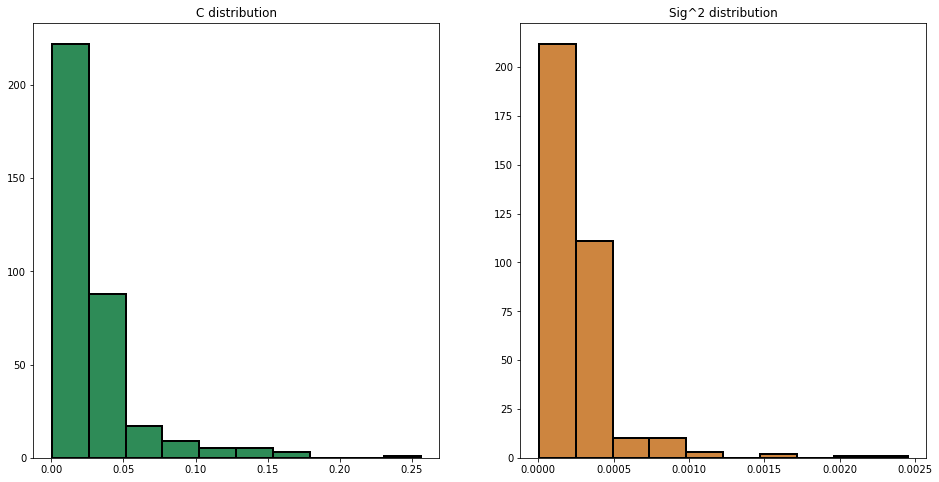

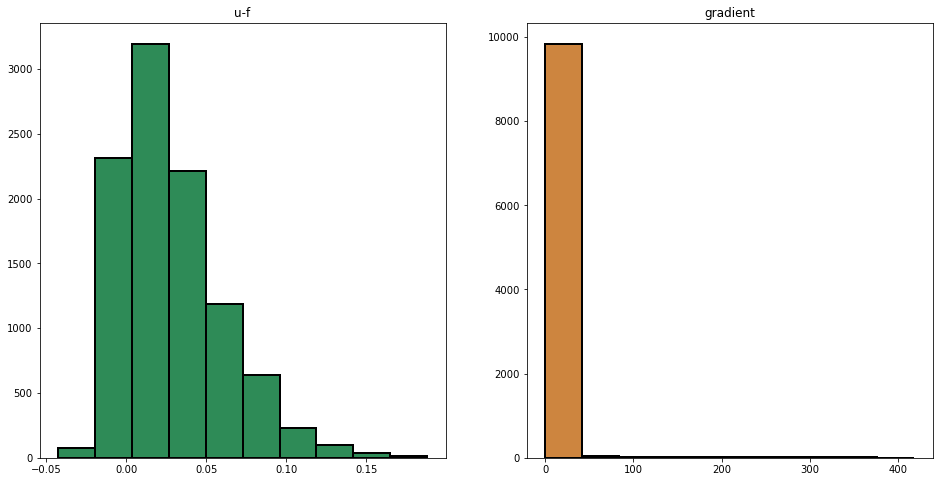

In [12]:
nfev = 100*(len(elm03.get_params())+1)
elm_solver(elm03, method='standard', max_nfev=nfev)

In [14]:
elm03.prune()
xc, yc, c, sig = elm03.get_params_mapped()
w = elm03.get_w()
mu = np.vstack([xc, yc]).T

In [15]:
components_dict03, isd_hist, kl_hist = gaussian_reduction(w, mu, sig, n_comp=1, metric='KL', verbose=True)

Merged components 261 and 303 with 4.1583412841561326e-07 KL dist and 1.0048519240677028e-10 ISD dist
Merged components 226 and 322 with 5.429641616790043e-07 KL dist and 5.231284821154026e-11 ISD dist
Merged components 91 and 200 with 7.155190583242752e-07 KL dist and 3.1722907827764886e-10 ISD dist
Merged components 167 and 320 with 7.751545284635778e-07 KL dist and 5.893902006865349e-12 ISD dist
Merged components 29 and 279 with 1.0013746853228744e-06 KL dist and 1.062626026930176e-11 ISD dist
Merged components 77 and 231 with 1.1125205279082645e-06 KL dist and 2.191629087480479e-11 ISD dist
Merged components 92 and 254 with 1.3009758199839977e-06 KL dist and 5.009396831416567e-10 ISD dist
Merged components 103 and 316 with 1.5316100721790873e-06 KL dist and 1.0351085929711888e-10 ISD dist
Merged components 62 and 187 with 1.7100838920265947e-06 KL dist and 3.2310077736763833e-10 ISD dist
Merged components 122 and 282 with 1.8629930094393146e-06 KL dist and 7.265788516644258e-10 ISD

Merged components 38 and 78 with 9.805956198701482e-06 KL dist and 1.6538070358317808e-09 ISD dist
Merged components 95 and 106 with 9.895753287637778e-06 KL dist and 4.265372849250974e-09 ISD dist
Merged components 7 and 227 with 9.912132735653736e-06 KL dist and 1.159641674643629e-08 ISD dist
Merged components 42 and 71 with 1.0083723990216443e-05 KL dist and 1.885934220686921e-08 ISD dist
Merged components 132 and 136 with 1.0220181374816649e-05 KL dist and 1.1391719593830275e-08 ISD dist
Merged components 119 and 168 with 1.025056345876457e-05 KL dist and 4.979361898181396e-10 ISD dist
Merged components 83 and 185 with 1.0462993857624842e-05 KL dist and 3.3680896117613e-09 ISD dist
Merged components 57 and 195 with 1.0559066341465502e-05 KL dist and 1.0391314028114034e-08 ISD dist
Merged components 72 and 234 with 1.0664464528415427e-05 KL dist and 2.1474479433337703e-08 ISD dist
Merged components 35 and 229 with 1.0675683273839474e-05 KL dist and 1.1504306208849175e-08 ISD dist
Me

Merged components 25 and 125 with 2.3146887040457863e-05 KL dist and 8.891835572365687e-08 ISD dist
Merged components 17 and 49 with 2.3223308867738736e-05 KL dist and 9.872272721642747e-09 ISD dist
Merged components 42 and 52 with 2.3248708611921113e-05 KL dist and 1.520532509082313e-08 ISD dist
Merged components 58 and 86 with 2.3331019378008554e-05 KL dist and 3.873515340231575e-08 ISD dist
Merged components 3 and 24 with 2.3658104777243057e-05 KL dist and 5.5032404768750714e-08 ISD dist
Merged components 55 and 102 with 2.3898641843210153e-05 KL dist and 8.722990887854454e-08 ISD dist
Merged components 49 and 103 with 2.4537062611230476e-05 KL dist and 5.924690393526222e-09 ISD dist
Merged components 38 and 85 with 2.489451183148073e-05 KL dist and 1.7368792166686252e-08 ISD dist
Merged components 27 and 77 with 2.5241426917544323e-05 KL dist and 1.5502184402270698e-08 ISD dist
Merged components 39 and 119 with 2.558564549616694e-05 KL dist and 3.54410548800303e-08 ISD dist
Merged 

Merged components 36 and 39 with 9.968130409242204e-05 KL dist and 2.991893819935899e-07 ISD dist
Merged components 0 and 17 with 0.00010186622712525994 KL dist and 6.19725562152069e-07 ISD dist
Merged components 47 and 63 with 0.00010319015698375365 KL dist and 2.4395504573685767e-07 ISD dist
Merged components 12 and 52 with 0.00010439510620679831 KL dist and 3.9162021326797935e-07 ISD dist
Merged components 2 and 27 with 0.00010462176751444095 KL dist and 7.733834364103364e-07 ISD dist
Merged components 33 and 51 with 0.00010504615058528396 KL dist and 3.085324002250561e-07 ISD dist
Merged components 24 and 38 with 0.00010550304132173202 KL dist and 5.696501085679916e-07 ISD dist
Merged components 7 and 60 with 0.00010899957581390635 KL dist and 1.634772756983499e-07 ISD dist
Merged components 9 and 50 with 0.00010972051083552817 KL dist and 1.1637360292932815e-07 ISD dist
Merged components 11 and 43 with 0.00011334809019329043 KL dist and 3.084778119383691e-07 ISD dist
Merged compon

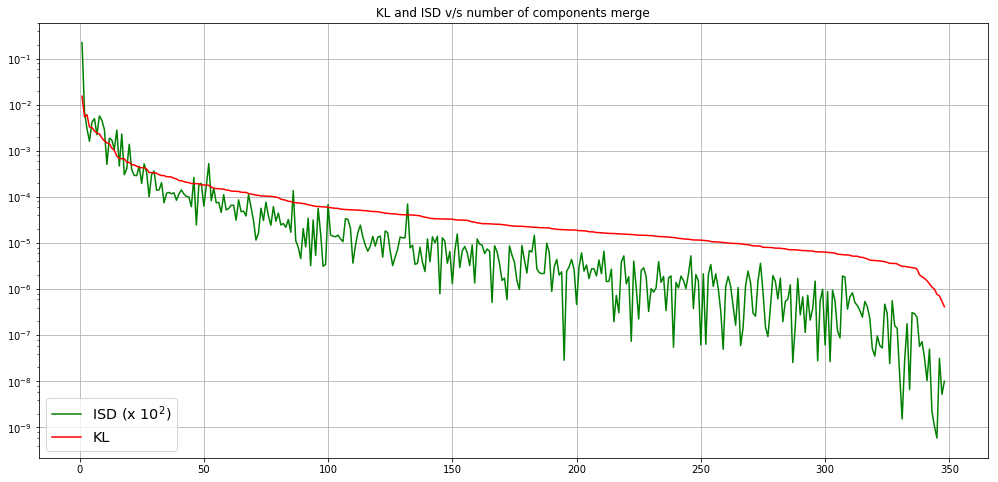

In [16]:
ncomp = list(range(len(isd_hist),0,-1))
plt.figure(figsize=(17,8))
plt.semilogy(ncomp, 1e2*isd_hist, "g-", label='ISD (x$\ 10^2$)')
plt.semilogy(ncomp, kl_hist, "r-", label='KL')
plt.title("KL and ISD v/s number of components merge")
plt.grid()
plt.legend(loc='lower left', fontsize="x-large")
plt.show()

In [17]:
interact(components_plot, elm=fixed(elm03), data=fixed(data), components_dict=fixed(components_dict03), n_comp=(1,20), dims=fixed(data.shape), resolution=fixed(1), n_levels=fixed(5))

<function graph.components_plot>

***
***
# `Antennae North`

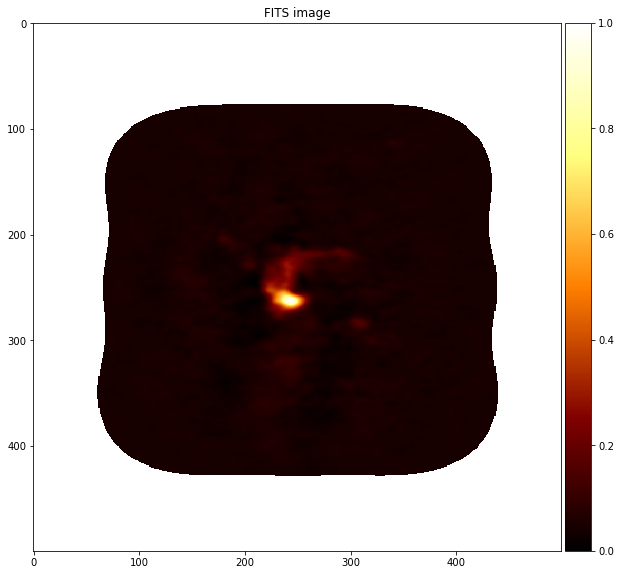

In [18]:
fits_path = '../data/images/Antennae_North.CO3_2Line.Clean.pcal1.image.mom0.fits'
x, y, data, dfunc = load_data(fits_path)
image_plot(data)

In [19]:
base_level = estimate_rms(data)
interact(thresholded_image_plot, data=fixed(data), level=FloatSlider(min=base_level,max=1.,step=0.01,value=base_level))

<function graph.thresholded_image_plot>

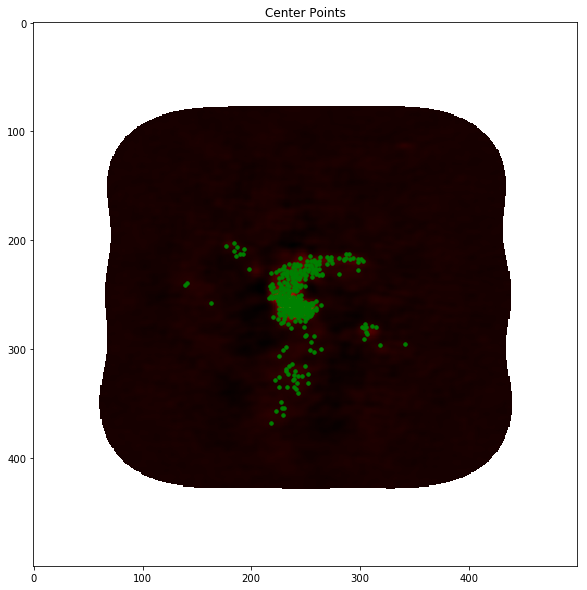

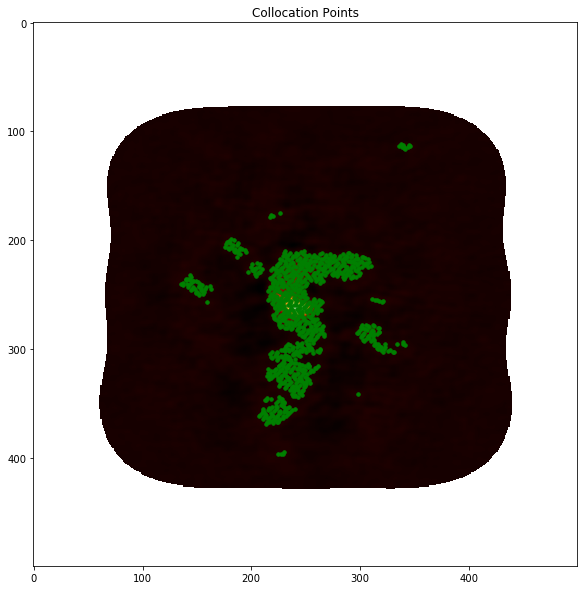

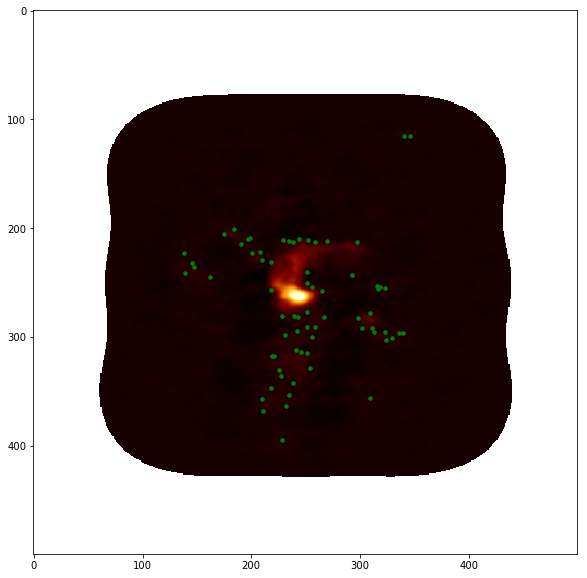

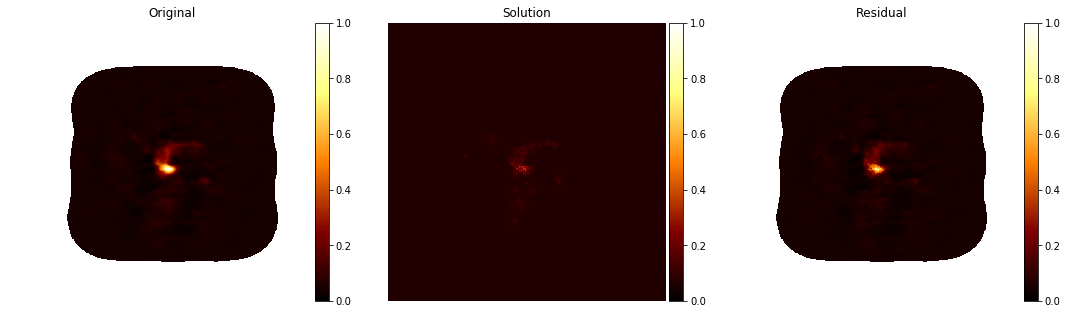

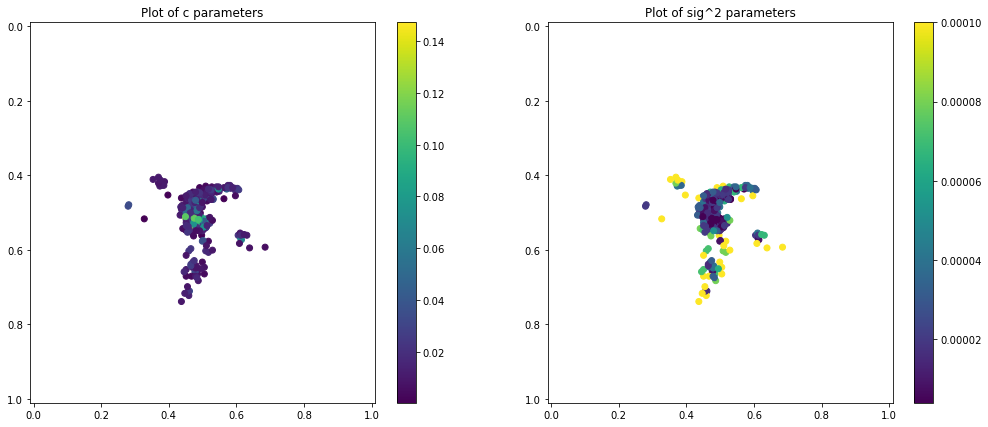

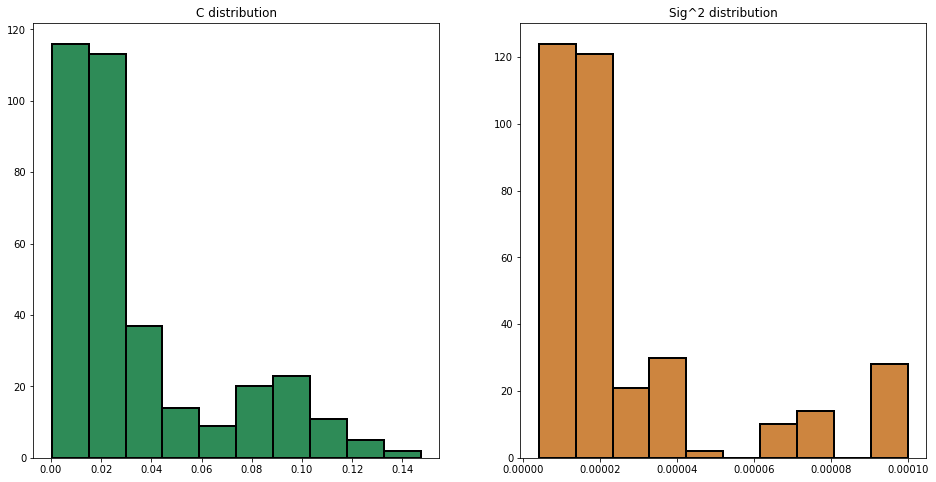

In [21]:
Nc = 350
Nb = int(0.2*Nc)
Ne = 3*Nc - Nb

center_points = random_centers_generation(data, Nc, base_level=base_level, power=2.)
#points = qrandom_centers_generation(dfunc, Nc+Ne, base_level, ndim=2)
#center_points = points[0:Nc]
#collocation_points = points[Nc:Nc+Ne]
collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
boundary_points = boundary_points_generation(data, base_level, Nb)


# right format
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
xb = boundary_points[:,0]
yb = boundary_points[:,1]


# visualizing the choosen points
points_plot(data, center_points=center_points, title="Center Points")
points_plot(data, center_points=collocation_points, title="Collocation Points")
points_plot(data, boundary_points=boundary_points, title="Boundary Points")


####################################
# Initial parameters estimation
####################################
minsig = ( 0.5*(1./data.shape[0] + 1./data.shape[1]) ) / 6.
maxsig = 30*minsig
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')

solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level)
params_plot(c0, sig0, xc, yc)
params_distribution_plot(c0, sig0)


elm04 = ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=1., lamb1=1., d1psi1=d1psi, 
                d1psi2=d1psi, d2psi2=d2psi, base_level=base_level, pix_freedom=1.)


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: False
status: 5
message: Number of calls to function has reached maxfev = 140100.
nfev: 140114

Residual stats:
Residual RMS: 0.0060410860797753515
Residual Variance: 3.540098692630903e-05
Flux Lost: 0.018261224328301972
Flux Addition: 0.01064404498611115
psi1(u-f): 0.008439371787198563
Exceeded Pixels: 3260
Sharpness: 92.48813978009768
psi2(grad u): 2.132583808984191
Total elapsed time: 799.6652040481567 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.23010662191598472
Mean min distance between collocation and center points: 0.010121315933173537

Homogeneity of solution:
Mean min distance in the (standarized) parameters space: 0.0637526185299719
Max min distance in the (standarized) parameters space: 0.30888065469707426


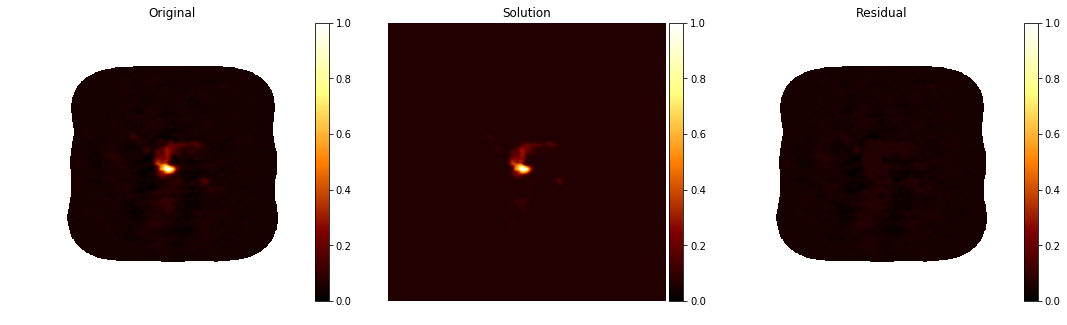

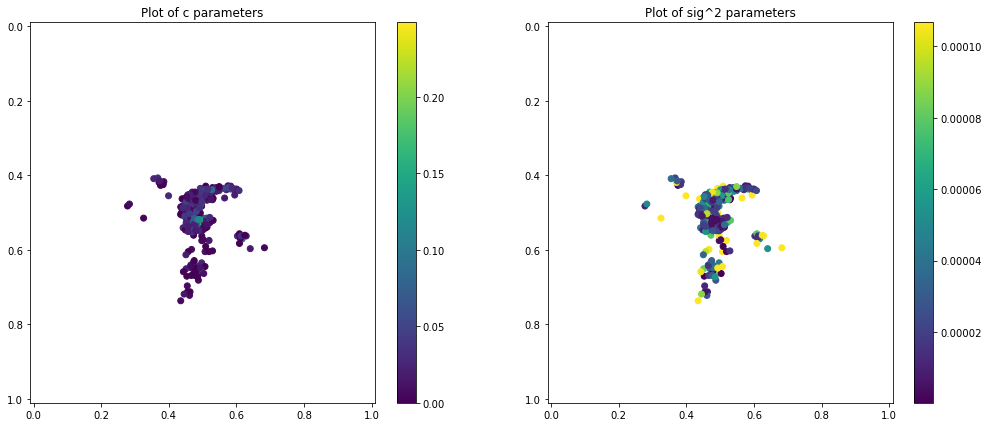

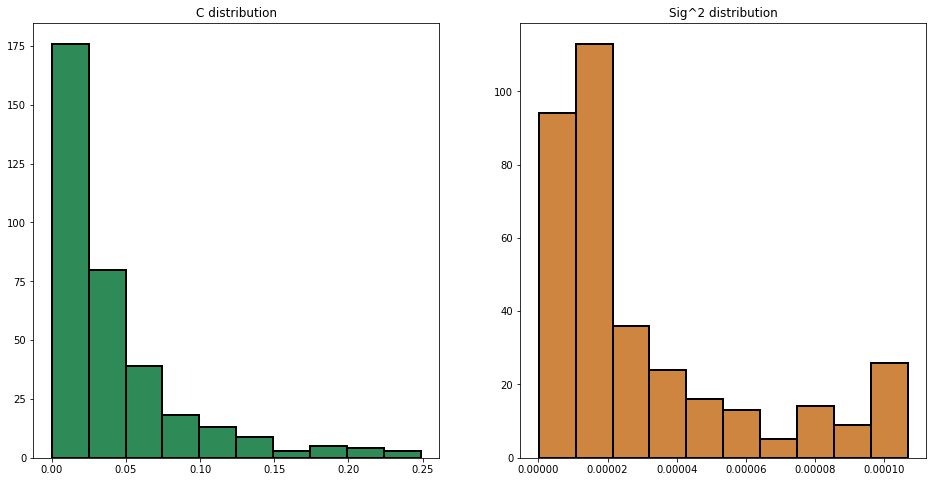

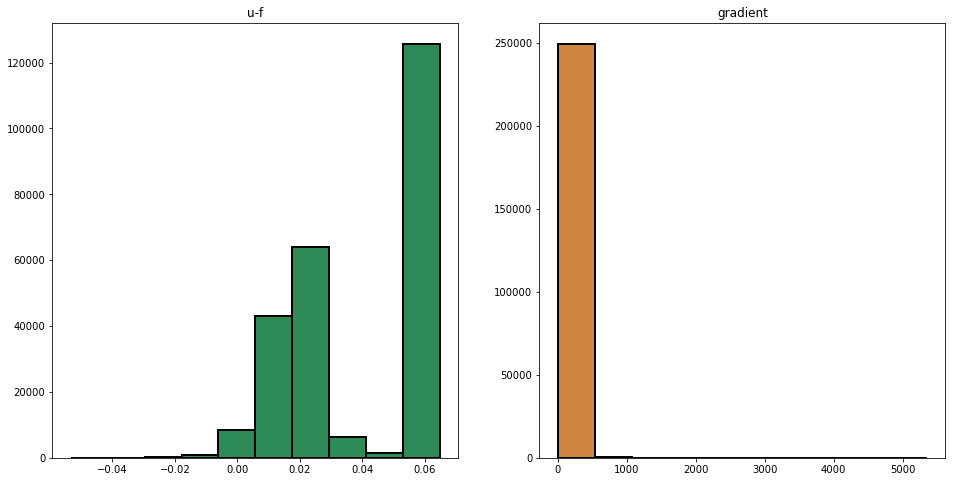

In [22]:
nfev = 100*(len(elm04.get_params())+1)
elm_solver(elm04, method='standard', max_nfev=nfev)

In [23]:
elm04.prune()
xc, yc, c, sig = elm04.get_params_mapped()
w = elm04.get_w()
mu = np.vstack([xc, yc]).T

In [24]:
components_dict04, isd_hist, kl_hist = gaussian_reduction(w, mu, sig, n_comp=1, metric='KL', verbose=True)

Merged components 241 and 279 with 5.436157269695036e-09 KL dist and 2.3729178031075995e-15 ISD dist
Merged components 173 and 284 with 9.68732737018063e-09 KL dist and 2.7359777587134056e-14 ISD dist
Merged components 147 and 330 with 1.104977375862516e-08 KL dist and 2.1989917232534807e-13 ISD dist
Merged components 67 and 299 with 1.3509383910198528e-08 KL dist and 2.493881995368061e-13 ISD dist
Merged components 163 and 166 with 1.6380317425737742e-08 KL dist and 2.4903821062567103e-13 ISD dist
Merged components 7 and 279 with 2.053520968822378e-08 KL dist and 2.545575687606284e-12 ISD dist
Merged components 211 and 260 with 2.646797322380755e-08 KL dist and 3.0646038719737237e-13 ISD dist
Merged components 74 and 233 with 3.5041676289944427e-08 KL dist and 1.897374237164769e-11 ISD dist
Merged components 36 and 141 with 3.668565900274126e-08 KL dist and 3.800406538135289e-12 ISD dist
Merged components 24 and 213 with 3.8197874544019274e-08 KL dist and 2.5863188681188514e-11 ISD di

Merged components 94 and 111 with 5.370148983591087e-07 KL dist and 1.904367968074706e-10 ISD dist
Merged components 195 and 209 with 5.518224957668337e-07 KL dist and 1.087286285961096e-09 ISD dist
Merged components 132 and 165 with 5.599330528093802e-07 KL dist and 1.6675998797801807e-09 ISD dist
Merged components 146 and 158 with 5.676438029519148e-07 KL dist and 8.47477796453398e-10 ISD dist
Merged components 183 and 184 with 5.736708625546284e-07 KL dist and 1.7037669497891128e-10 ISD dist
Merged components 47 and 131 with 5.802052672727528e-07 KL dist and 8.100476604295545e-10 ISD dist
Merged components 46 and 123 with 6.158225447076729e-07 KL dist and 1.1765083559978626e-09 ISD dist
Merged components 162 and 195 with 6.188112819715964e-07 KL dist and 9.41092504768001e-10 ISD dist
Merged components 79 and 192 with 6.312655561240575e-07 KL dist and 7.235109974142322e-10 ISD dist
Merged components 87 and 184 with 6.408541357852947e-07 KL dist and 3.2622046985106237e-10 ISD dist
Mer

Merged components 29 and 115 with 2.153281114688471e-06 KL dist and 1.2413064325620046e-08 ISD dist
Merged components 29 and 67 with 2.15779803806979e-06 KL dist and 3.9606312816756215e-10 ISD dist
Merged components 2 and 14 with 2.1612578421467172e-06 KL dist and 4.6351287779932795e-10 ISD dist
Merged components 80 and 98 with 2.223735264554098e-06 KL dist and 3.0399161646993816e-09 ISD dist
Merged components 58 and 137 with 2.273891957048728e-06 KL dist and 8.632481579421297e-10 ISD dist
Merged components 11 and 118 with 2.310003953812751e-06 KL dist and 1.4994983085887845e-08 ISD dist
Merged components 38 and 53 with 2.329183854192637e-06 KL dist and 1.4259518176368904e-09 ISD dist
Merged components 24 and 60 with 2.3680741950555983e-06 KL dist and 1.0986362065389838e-09 ISD dist
Merged components 47 and 104 with 2.4126921783277806e-06 KL dist and 2.821609846574578e-09 ISD dist
Merged components 58 and 62 with 2.4251311132139728e-06 KL dist and 1.6101419664912133e-08 ISD dist
Merged

Merged components 7 and 50 with 1.2606935412726302e-05 KL dist and 2.8456688095689558e-08 ISD dist
Merged components 14 and 44 with 1.3574237398524588e-05 KL dist and 1.8626728712029672e-07 ISD dist
Merged components 6 and 41 with 1.360843610642652e-05 KL dist and 2.182822646298755e-08 ISD dist
Merged components 5 and 35 with 1.368752632013894e-05 KL dist and 3.7705874809789544e-08 ISD dist
Merged components 6 and 27 with 1.4025669524918419e-05 KL dist and 1.4763758748218383e-08 ISD dist
Merged components 21 and 46 with 1.4517861368473209e-05 KL dist and 9.154094915366712e-08 ISD dist
Merged components 4 and 35 with 1.4646173830724332e-05 KL dist and 1.2067066175867401e-07 ISD dist
Merged components 23 and 32 with 1.5366216521909616e-05 KL dist and 2.8167075738337548e-08 ISD dist
Merged components 14 and 19 with 1.5412330943575625e-05 KL dist and 2.4250730802337773e-07 ISD dist
Merged components 6 and 9 with 1.5634443191425175e-05 KL dist and 4.102187012278805e-08 ISD dist
Merged compo

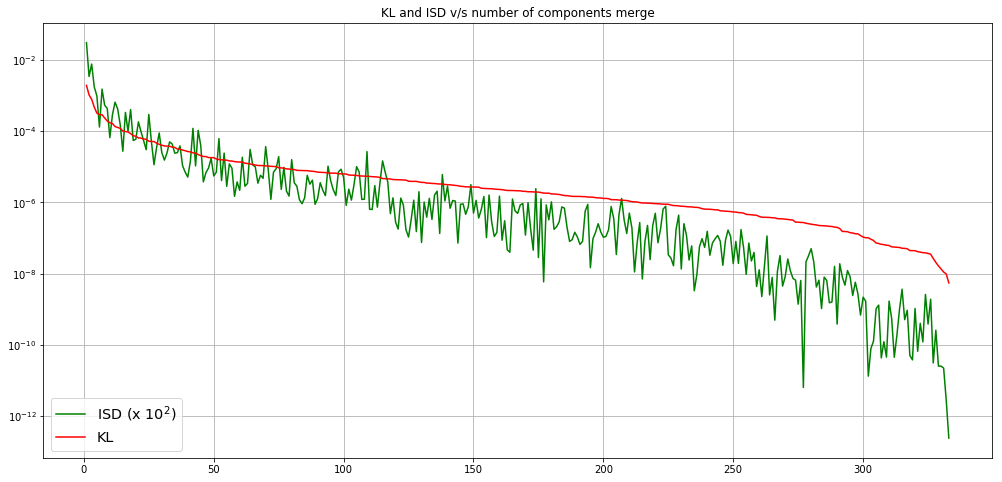

In [25]:
ncomp = list(range(len(isd_hist),0,-1))
plt.figure(figsize=(17,8))
plt.semilogy(ncomp, 1e2*isd_hist, "g-", label='ISD (x$\ 10^2$)')
plt.semilogy(ncomp, kl_hist, "r-", label='KL')
plt.title("KL and ISD v/s number of components merge")
plt.grid()
plt.legend(loc='lower left', fontsize="x-large")
plt.show()

In [26]:
interact(components_plot, elm=fixed(elm04), data=fixed(data), components_dict=fixed(components_dict04), n_comp=(1,20), dims=fixed(data.shape), resolution=fixed(1), n_levels=fixed(5))

<function graph.components_plot>